# Проверка гипотез по увеличению выручки в интернет-магазине

## План исследования
1. Приоритезация гипотез
2. А/Б-тестирование
3. Анализ полученных результов

## Описание данных

Файл - `Hypothesis`
<br>**Hypothesis** — краткое описание гипотезы; </br>
**Reach** — охват пользователей по 10-балльной шкале; </br>
**Impact** — влияние на пользователей по 10-балльной шкале;</br>
**Confidence** — уверенность в гипотезе по 10-балльной шкале;</br>
**Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.</br>

Файл - `Orders`
<br>**transactionId** — идентификатор заказа;</br>
**visitorId** — идентификатор пользователя, совершившего заказ;</br>
**date** — дата, когда был совершён заказ;</br>
**revenue** — выручка заказа;</br>
**group** — группа A/B-теста, в которую попал заказ.</br>

Файл - `Visitors`
<br>**date** — дата;</br>
**group** — группа A/B-теста;</br>
**visitors** — количество пользователей в указанную дату в указанной группе A/B-теста</br>

# Изучение входных данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import datetime as dt
import math as mth
from scipy import stats as st
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_colwidth', 500)

In [2]:
# загрузка данных о гипотезах, заказах и пользователях
data = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

print('DATA')
data.info()

print('\nORDERS')
orders.info()

print('\nVISITORS')
visitors.info()

DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

ORDERS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

VISITORS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (

В данных присутствуют некорректно оформленные названия столбцов и строковый тип данных в столбцах `date`, который необходимо заменить на тип datetime. Пропусков в таблицах не обнаружено. Приведём полученные данные к стандарту оформления.

In [3]:
# приведение названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

# приведение названия столбцов к нормативу
orders = orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'})

# приведение столбца "date" в таблице с заказами к типу даты
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

# приведение столбца "date" в таблице с пользователями к типу даты
visitors['date'] = pd.to_datetime(visitors['date'])

In [4]:
# проверка даты в датафреймах
print('Диапазон дат в столбце "Orders": {} - {}'.format(orders['date'].min(), orders['date'].max()))
print('Диапазон дат в столбце "Visitors": {} - {}'.format(visitors['date'].min(), visitors['date'].max()))

Диапазон дат в столбце "Orders": 2019-08-01 00:00:00 - 2019-08-31 00:00:00
Диапазон дат в столбце "Visitors": 2019-08-01 00:00:00 - 2019-08-31 00:00:00


Данные в обоих файлах представлены за август 2019 года. 

In [5]:
# проверка результатов изменений
print('DATA')
data.info()

print('\nORDERS')
orders.info()

print('\nVISITORS')
visitors.info()

DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

ORDERS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB

VISITORS
<c

In [6]:
# проверка на полные дубликаты
print('Кол-во дубликатов в visitors:', visitors.duplicated().sum())
print('Кол-во дубликатов в orders:', orders.duplicated().sum())

Кол-во дубликатов в visitors: 0
Кол-во дубликатов в orders: 0


**Вывод**
<br>Исходные данные приведены в порядок, пропусков и дубликатов в таблицах не обнаружено, даты из разных таблиц совпадают. Можно приступать к анализу.</br>

# Приоритизация гипотез

In [7]:
# таблица с оценками параметров гипотез
display(data)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [8]:
# приоритизация по "ice"
data['ice'] = data['impact'] * data['confidence'] / data['efforts']
display(data[['hypothesis', 'ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее перспективные гипотезы по `ice` под номерами: 8, 0, 7. Больше всего баллов у 8 гипотезы, размер которой составил 16,2. Меньше всего у гипотезы под номером 4 в размере 1 балла.

In [9]:
# приоритизация по "rice"
data['rice'] = (data['reach'] * data['impact'] * data['confidence']) / data['efforts']
display(data[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [10]:
# проранжируем результаты в одной таблице
data['ice_rank'] = data['ice'].rank(ascending = False).astype(int)
data['rice_rank'] = data['rice'].rank(ascending = False).astype(int)
data[['hypothesis', 'ice_rank', 'rice_rank']].sort_values('rice_rank')

,hypothesis,ice_rank,rice_rank
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",3,1
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",5,2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",4,3
8,"Запустить акцию, дающую скидку на товар в день рождения",1,5
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",6,7
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",7,7
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",9,9


## Промежуточный вывод
С учетом охвата аудитории, гипотеза под номером 7 переместилась на первоем место по важности, а 8 гипотеза, которая являлась наиболее приоритетной с точки зрения `ice`, сместилась на пятую позицию в расчете `rice`. Это произошло из-за очень малого количества пользователей, которых затронет это изменение. В то время как у 7 гипотезы параметр *reach* составил 10 баллов, у гипотезы под номером 8 всего 1 балл.</br>
Таким образом, с учётом охвата изменений, наиболее приоритетной гипотезой станет гипотеза под номером 7.

# Анализ А/В-теста

In [11]:
# проверка на корректность разбиения пользователей на группы
re = orders[orders['group'] == 'A']['visitor_id'].isin(orders[orders['group'] == 'B']['visitor_id'])
re.value_counts()

False    468
True      89
Name: visitor_id, dtype: int64

In [12]:
# удаление пользователей, попавших в обе группы
bad_ids = orders[orders['group'] == 'A'][re]['visitor_id']
orders = orders[~orders['visitor_id'].isin(bad_ids)]

print(
    (orders[orders['group'] == 'A']['visitor_id'].isin(
        orders[orders['group'] == 'B']['visitor_id'])
    ).value_counts()
)

False    468
Name: visitor_id, dtype: int64


Проверим размеры выборок и количество покупок для групп А и В.

In [13]:
# проверка количества посетителей
print('Кол-во посетителей в группе А: {}\n'
      'Кол-во посетителей в группе В: {}'.format(visitors[visitors['group'] == 'A']['visitors'].sum(), 
                                                 visitors[visitors['group'] == 'B']['visitors'].sum()
                                                )
)

# проверка количества покупателей
print('Кол-во покупателей в группе А: {}\n'
      'Кол-во покупателей в группе В: {}'.format(len(orders[orders['group'] == 'A']),
                                                 len(orders[orders['group'] == 'B'])
                                                )
)

# проверка размера выборки с посетителями на статистическую значимость
alpha = 0.05

results = st.mannwhitneyu(visitors[visitors['group']=='A']['visitors'], visitors[visitors['group']=='B']['visitors'])

print('\nP-value: {:.2f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Разница в кол-ве посетителей в группах A и B статистически значима.')
else:
    print('Разница в кол-ве посетителей в группах A и B статистически не значима.')

Кол-во посетителей в группе А: 18736
Кол-во посетителей в группе В: 18916
Кол-во покупателей в группе А: 468
Кол-во покупателей в группе В: 548

P-value: 0.73
Разница в кол-ве посетителей в группах A и B статистически не значима.


In [14]:
# расчет конверсии двух выборок
initial_conversion = len(orders[orders['group'] == 'A']) / visitors[visitors['group'] == 'A']['visitors'].sum()
resulting_conversion = len(orders[orders['group'] == 'B']) / visitors[visitors['group'] == 'B']['visitors'].sum()

print('Конверсия до внесения изменений: {:.3f}'.format(initial_conversion))
print('Конверсия после внесения изменений: {:.3f}'.format(resulting_conversion))
print('Относительное изменение конверсии после изменений: {:.2f}'.format(abs(resulting_conversion/initial_conversion - 1)))
print('Общее кол-во посетителей:', visitors['visitors'].sum())

Конверсия до внесения изменений: 0.025
Конверсия после внесения изменений: 0.029
Относительное изменение конверсии после изменений: 0.16
Общее кол-во посетителей: 37652


Рассчитаем минимально необходимый объём выборки, на которой будет заметно изменение показателя, если оно есть. В расчетах используем калькулятор https://www.evanmiller.org/ab-testing/sample-size.html. За основу расчетов возьмем относительное различие между группами теста в 16%, базовую конверсию 2.5%, мощность теста 80% и уровень значимости 5%. С учётом перечисленных параметров, минимальный размер выборки должен составлять 24465. В исходных данных размер выборки составляет 37652. Это означает, что выборка представлена в достаточном объёме и можно производить расчеты.

In [15]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups.apply(
    lambda x: orders[
              np.logical_and(
              orders['date'] <= x['date'], orders['group'] == x['group'])
                    ].agg(
                    {
                        'date': 'max',
                        'group': 'max',
                        'transaction_id': 'nunique',
                        'visitor_id': 'nunique',
                        'revenue': 'sum',
                    }
                    ),
                    axis=1,
).sort_values(by=['date', 'group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
              np.logical_and(
              visitors['date'] <= x['date'], visitors['group'] == x['group'])
                      ].agg(
                      {
                          'date': 'max', 
                          'group': 'max', 
                          'visitors': 'sum',
                      }
                      ),
                      axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

display(cumulativeData.head(5))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


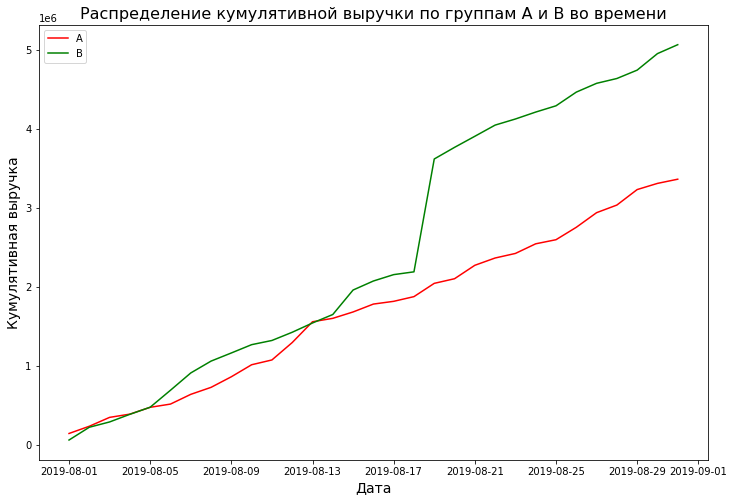

In [16]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12, 8))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A', color='r')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B', color='g')

plt.legend()
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кумулятивная выручка', fontsize=14)
plt.title('Распределение кумулятивной выручки по группам А и В во времени', fontsize=16)
plt.show()

График равномерно увеличивается в течении всего теста, что является позитивным сигналом. Выручка группы В стабильно выше выручки группы А, однако график группы В имеет резкий рост в районе 18 августа 2019 года. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке.

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов.

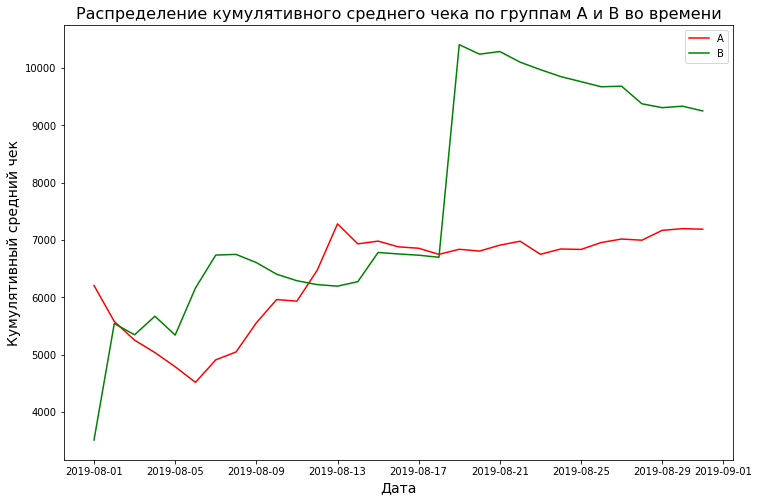

In [17]:
plt.figure(figsize=(12, 8))

# Строим график среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A', color='r')

# Строим график среднего чека группы В
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B', color='g')

plt.legend()
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кумулятивный средний чек', fontsize=14)
plt.title('Распределение кумулятивного среднего чека по группам А и В во времени', fontsize=16)
plt.show()

Кумулятивное значение среднего чека по сегментам имеет сильные колебания. В группе В всё также выделяется резкий рост показателя в районе 18 августа 2019 года, что может быть связано с крупным заказом. На данный момент принимать решение по этой метрике рано. Требуется дополнительный анализ выбросов, которые так сильно искажают результаты. 

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом **axhline()**.

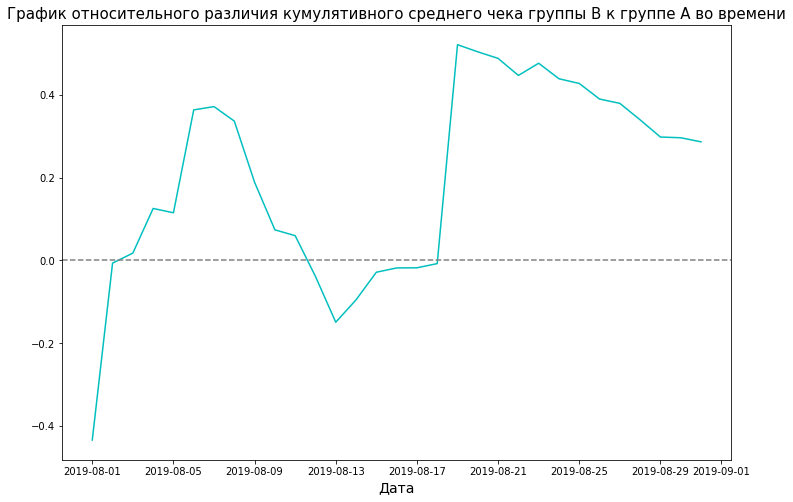

In [18]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 8))

# cтроим отношение средних чеков
plt.plot(
    mergedCumulativeRevenue['date'], 
    (
        mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']
    )/
    (
        mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']
    )-1, color = 'c'
)

# добавим ось X
plt.axhline(y = 0, color='gray', linestyle='--') 

plt.xlabel('Дата', fontsize=14)
plt.title('График относительного различия кумулятивного среднего чека группы B к группе A во времени', fontsize=15)

plt.show()

В нескольких точках график относительного различия между сегментами значительно и резко изменялся. Видимо, именно тогда были совершены аномальные заказы.

Аналогично проанализируем график кумулятивной конверсии. Зададим масштаб осей методом **plt.axis()**.

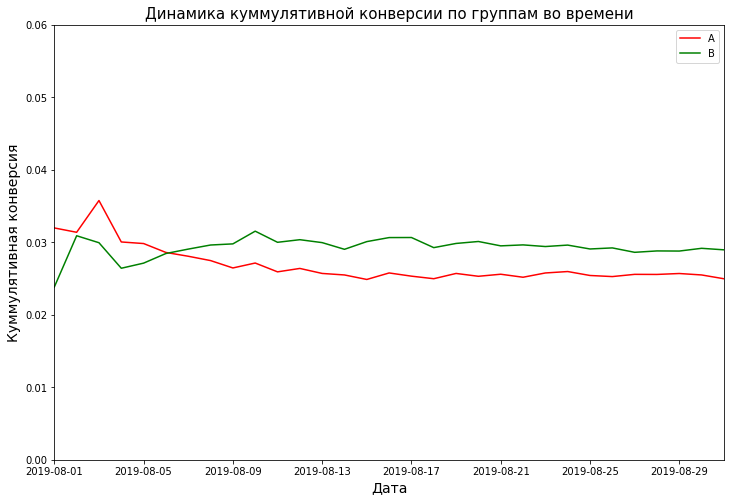

In [19]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(12, 8))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A', color = 'r')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B', color = 'g')

plt.legend()
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Куммулятивная конверсия', fontsize=14)
plt.title('Динамика куммулятивной конверсии по группам во времени', fontsize=15)

# задаем масштаб осей
plt.axis([cumulativeData['date'].min(), cumulativeData['date'].max(), 0, 0.06])

plt.show()

В начале теста сегмент А имел большую конверсию, но постепенно сегмент В выровнялся и зафиксировался примерно около одного значения, больше значения сегмента А. В данном случае был изменен масштаб графика, чтобы убрать колебания и установить конверсию около своего среднего значения.

Построим график относительного различия кумулятивных конверсий.

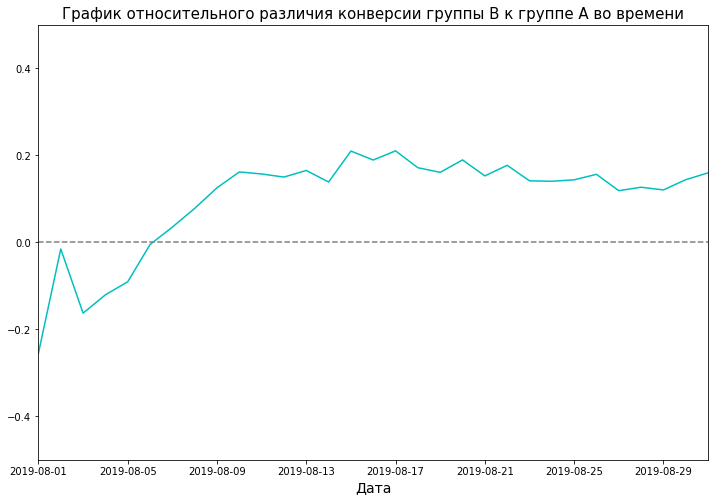

In [20]:
# собираем данные в один датафрейм
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 8))

plt.plot(
    mergedCumulativeConversions['date'], 
    mergedCumulativeConversions['conversionB'] / mergedCumulativeConversions['conversionA'] - 1, color = 'c'
)

plt.xlabel('Дата', fontsize=14)
plt.title('График относительного различия конверсии группы B к группе A во времени', fontsize=15)

plt.axhline(y = 0, color='gray', linestyle='--')
plt.axis([mergedCumulativeConversions['date'].min(), mergedCumulativeConversions['date'].max(), -0.5, 0.5])

plt.show()

Почти с самого начала теста группа В лидирует по конверсии в среднем на 16% относительно группы А. Однако сейчас делать какие-либо выводы по тесту нельзя, так как сперва нужно проанализировать аномалии, возможно, они изменят картину.

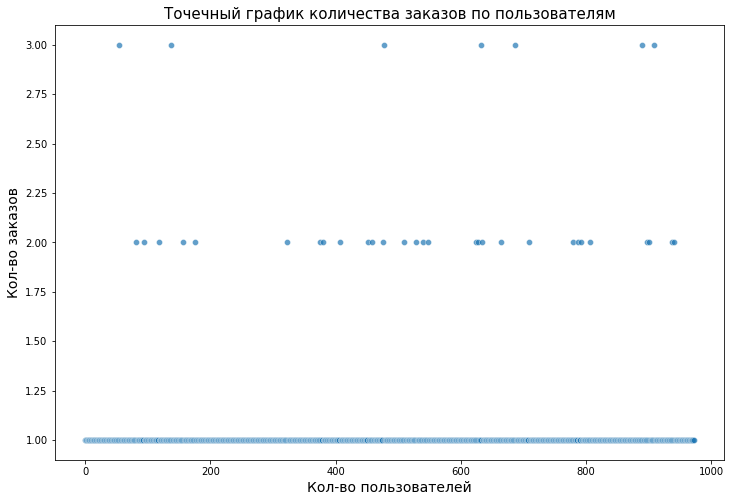

In [21]:
# таблица с числом заказов по пользователям
ordersByUsers = (
    orders.groupby('visitor_id', as_index = False)
    .agg({'transaction_id':'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.figure(figsize=(12, 8))
sns.scatterplot(x = x_values, y = ordersByUsers['orders'], alpha = 0.7)
plt.xlabel('Кол-во пользователей', fontsize=14)
plt.ylabel('Кол-во заказов', fontsize=14)
plt.title('Точечный график количества заказов по пользователям', fontsize=15)

plt.show()

Пользователей, заказавших более 2-х раз совсем мало. Они вполне могут быть аномальными. Для этого посчитаем выборочные перцентили количества заказов по пользователям.

In [22]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


Не более 5% пользователей совершали больше одного заказа. И не более 1% пользователей - больше двух заказов. За нижнюю границу количества заказов примем 99-й перцентиль или до 2-х заказов, и отсеим пользователей по ней.

In [23]:
# лимит на кол-во заказов
order_limit = 2

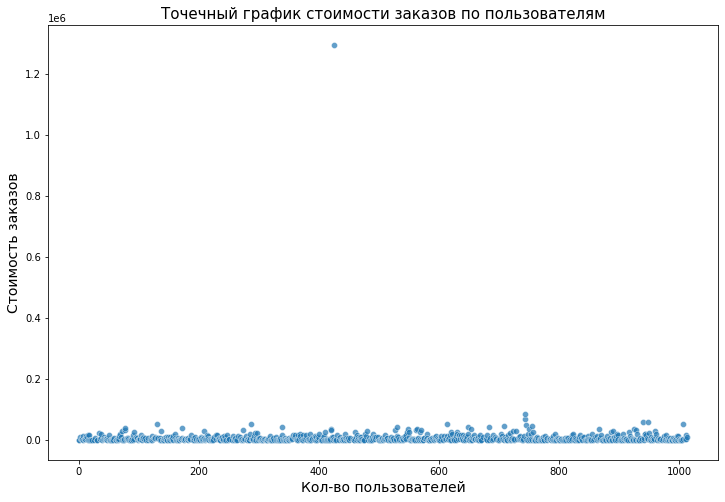

In [24]:
# точечный график стоимости заказов
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(12, 8))
sns.scatterplot(x = x_values, y = orders['revenue'], alpha = 0.7)
plt.xlabel('Кол-во пользователей', fontsize = 14)
plt.ylabel('Стоимость заказов', fontsize = 14)
plt.title('Точечный график стоимости заказов по пользователям', fontsize = 15)

plt.show()

Есть несколько дорогих заказов, особенно вызывает подозрение заказ стоимостью более 1.2 млн. у.е. Найдем выборочные перцентили стоимости заказов.

In [25]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более чем у 5% заказов чек дороже 26.8 тыс. у.е. И не больше, чем у 1% заказов - дороже 53.9 тыс. у.е. В качестве нижней границы также возьмем 99-й перцентиль или чек до 53.9 тыс. у.е. 

In [26]:
# лимит на сумму покупки
revenue_limit = 53904

Для рассчетов статистической значимости используем критерий Манна-Уитни, поскольку в данных присутствуют выбросы, сдвигающие параметрические результаты. В качестве нулевой гипотезы (Но) примем отсутствие различий между группами, соответственно альтернативная гипотеза (Н1) будет подразумевать наличие статистически значимых различий. Уровень статистической значимости примем за 5%.

In [27]:
# расчет стат.значимости различий в конверсии между группами по "сырым" данным
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'A']['visitors'].sum() - len(ordersByUsersA)
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B']['visitors'].sum() - len(ordersByUsersB)
            ),
            name='orders',
        ),
    ],
    axis=0,
)

results = st.mannwhitneyu(sampleA, sampleB)
print('P-value: {:.3f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. По "сырым" данным в конверсии групп A и B разница статистически значима.')
else:
    print('Не отвергаем нулевую гипотезу. По "сырым" данным разницы в конверсии групп A и B нет.')

print('\nОтносительный прирост конверсии группы B по отношению к группе A: {:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))    

P-value: 0.011
Отвергаем нулевую гипотезу. По "сырым" данным в конверсии групп A и B разница статистически значима.

Относительный прирост конверсии группы B по отношению к группе A: 0.160


Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем гипотезы:

Н0 - различий в среднем чеке между группами по «сырым» данным нет

Н1 - различия в среднем чеке между группами по «сырым» данным есть

Пороговое значение alpha примем за 5%

In [28]:
# расчет стат.значимости различий в среднем чеке между группами по "сырым" данным
results = st.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])
print('P-value: {:.3f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Наблюдаемое различие среднего чека группы B по отношению к группе A в {:.1%} является статистически значимым.'.format(
    orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean() - 1))
else:
    print('Не отвергаем нулевую гипотезу. Наблюдаемое различие среднего чека группы B по отношению к группе A в {:.1%} не является статистически значимым.'.format(
    orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean() - 1))

P-value: 0.829
Не отвергаем нулевую гипотезу. Наблюдаемое различие среднего чека группы B по отношению к группе A в 28.7% не является статистически значимым.


Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

Сформулируем гипотезы:

Н0 - различий в конверсиях между группами по «очищенным» данным нет

Н1 - различия в конверсиях между группами по «очищенным» данным есть

Пороговое значение alpha примем за 5%

In [29]:
# найдем кол-во аномальных пользователей
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > order_limit]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > order_limit]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_limit]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print('Кол-во аномальных пользователей -', abnormalUsers.count())

Кол-во аномальных пользователей - 16


In [30]:
# расчет стат.значимости различий в конверсии между группами по "очищенным" данным
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'A']['visitors'].sum() - len(ordersByUsersA)
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B']['visitors'].sum() - len(ordersByUsersB)
            ),
            name='orders',
        ),
    ],
    axis=0,
)

results = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)
print('P-value: {:.3f}'.format(results.pvalue))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. По "очищенным" данным в конверсии групп A и B разница статистически значима.')
else:
    print('Не отвергаем нулевую гипотезу. По "очищенным" данным разницы в конверсии групп A и B нет.')

print('\nОтносительный прирост конверсии группы B по отношению к группе A: {:.3f}'.format(
    sampleBFiltered.mean() / sampleAFiltered.mean() - 1)
)    

P-value: 0.007
Отвергаем нулевую гипотезу. По "очищенным" данным в конверсии групп A и B разница статистически значима.

Относительный прирост конверсии группы B по отношению к группе A: 0.189


Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Сформулируем гипотезы:

Н0 - различий в среднем чеке между группами по «очищенным» данным нет

Н1 - различия в среднем чеке между группами по «очищенным» данным есть

Пороговое значение alpha примем за 5%

In [31]:
# расчет стат.значимости различий в среднем чеке между группами по "очищенным" данным 
results = st.mannwhitneyu(
            orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
            orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
)

print('P-value: {:.3f}'.format(results.pvalue))  

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. По "очищенным" данным разница в средних чеках между группами А и В статистически значима.')
else:
    print('Не отвергаем нулевую гипотезу. По "очищенным" данным различий в средних чеках между группами А и В нет.')


print(
    '\nОтносительный прирост среднего чека группы B по отношению к группе A: {:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        -1
    )
)

P-value: 0.788
Не отвергаем нулевую гипотезу. По "очищенным" данным различий в средних чеках между группами А и В нет.

Относительный прирост среднего чека группы B по отношению к группе A: -0.032


# Вывод

В текущем проекте были рассмотрены 9 гипотез интернет-магазина и выполнена их приоритизация двумя разными методами: RICE и ICE. По методу ICE наиболее приоритетная гипотеза №8 - запустить акцию, дающую скидку на товар в день рождения. По методу RICE - №7 - добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. Основное отличие данных методов в том, что RICE берет в расчет количество пользователей, которых затронет это изменение. 

На основе анализа кумулятивных метрик были сделаны следущие выводы:
1. Кумулятивная выручка группы В стабильно выше группы А как по "сырым", так и по "очищенным" данным;
2. Кумулятивная конверсия сегмента В выше сегмента А.

На основе А/Б-теста по "сырым" и "очищенным" данным были сделаны следующие выводы:
1. Есть статистически значимое различие в конверсии между группами как по "сырым" данным, так и после фильтрации аномалий;
2. Статистически значимого различия по среднему чеку не обнаружено.

На основании проведенного A/B-тестирования рекомендуется остановить тест и зафиксировать победу группы В.